In [1]:
%matplotlib inline

import psrqpy
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as pl

from collections import OrderedDict

In [2]:
q = psrqpy.QueryATNF(params=['P0'])

AttributeError: Unknown property linestype

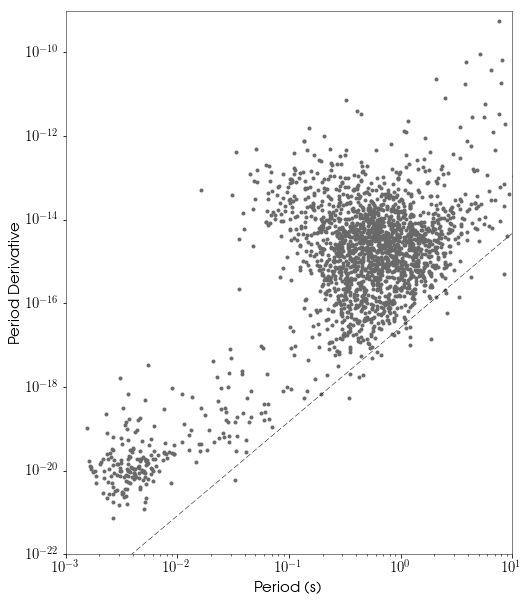

In [3]:
fig = q.ppdot()

(0.0025118864315095794, 3.9798438910271717e-16)
(0.0025118864315095794, 3.9798438910271716e-17)
(0.0025118864315095794, 3.9798438910271716e-18)
(0.0025118864315095794, 3.9798438910271715e-19)
(0.0025118864315095794, 3.979843891027171e-20)
(2.5118864315095797, 3.887765337436504e-20)
(2.5118864315095797, 3.8877653374365044e-18)
(2.5118864315095797, 3.8877653374364884e-16)
(2.5118864315095797, 3.887765337436488e-14)
(2.5118864315095797, 3.887765337436488e-12)


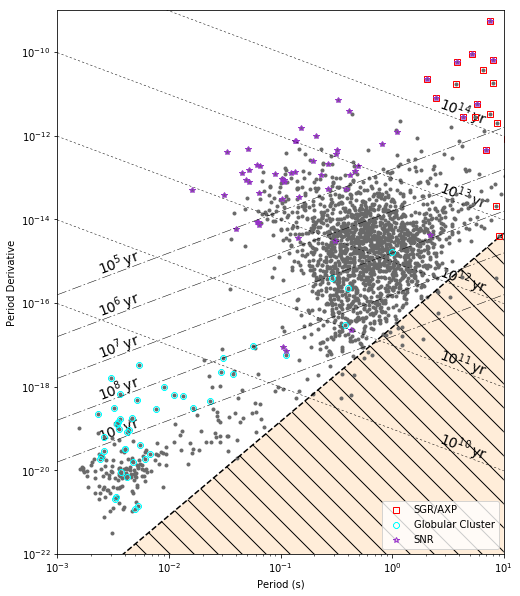

In [20]:
fig, ax = pl.subplots(figsize=(8,10))

intrinsicpdot = True

periods = t['P0']
pdots = t['P1']
if intrinsicpdot: # use instrinsic period derivatives if requested
    ipdotidx = np.isfinite(t['P1_I'])
    pdots[ipdotidx] = t['P1_I'][ipdotidx]

# get only finite values
pidx = (np.isfinite(periods)) & (np.isfinite(pdots))
periods = periods[pidx]
pdots = pdots[pidx]
assocs = t['ASSOC'][pidx]   # associations
types = t['TYPE'][pidx]     # pulsar types
binaries = t['BINARY'][pidx] # binary pulsars

# not get only positive pdot values
pidx = pdots > 0.
periods = periods[pidx]
pdots = pdots[pidx]
assocs = assocs[pidx]   # associations
types = types[pidx]     # pulsar types
binaries = binaries[pidx] # binary pulsars

# check whether to exclude globular cluster pulsars that could have contaminated spin-down value
excludeGCs = False
if excludeGCs:
    nongcidxs = np.flatnonzero(np.char.find(assocs,'GC:')==-1) # use '!=' to find GC indexes
    periods = periods[nongcidxs]
    pdots = pdots[nongcidxs]
    assocs = assocs[nongcidxs]
    types = types[nongcidxs]
    binaries = binaries[nongcidxs]

# plot pulsars
ax.loglog(periods, pdots, marker='.', color='dimgrey', linestyle='none')
ax.set_xlabel(r'Period (s)')
ax.set_ylabel(r'Period Derivative')

periodlims = [10**np.floor(np.min(np.log10(periods))), 10.*int(np.ceil(np.max(pdots)/10.))]
pdotlims = [10**np.floor(np.min(np.log10(pdots))), 10**np.ceil(np.max(np.log10(pdots)))]
ax.set_xlim(periodlims);
ax.set_ylim(pdotlims);

adddeathline=True
filldeath = True

if adddeathline:
    deathpdots = 10**psrqpy.utils.death_line(np.log10(periodlims))
    ax.loglog(periodlims, deathpdots, 'k--')
    
    if filldeath:
        ax.fill_between(periodlims, deathpdots, pdotlims[0], linestyle='-', alpha=0.15,
                        facecolor='darkorange', hatch='\\')
        
# add markers for each pulsar type
#showtypes = ['all']
showtypes = ['BINARY', 'AXP']
if isinstance(showtypes, basestring):
    nshowtypes = [showtypes]
else:
    nshowtypes = showtypes

markertypes = {}
markertypes['AXP'] = {'marker': 's', 'color': 'red', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['BINARY'] = {'marker': 'o', 'color': 'grey', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['HE'] = {'marker': 'D', 'color': 'orange', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['RRAT'] = {'marker': 'h', 'color': 'green', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['NRAD'] = {'marker': 'v', 'color': 'blue', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['XINS'] = {'marker': '^', 'color': 'magenta', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['GC'] = {'marker': '8', 'color': 'cyan', 'markerfacecolor': 'none', 'linestyle': 'none'}
markertypes['SNR'] = {'marker': '*', 'color': 'darkorchid', 'markerfacecolor': 'none', 'linestyle': 'none'}

# legend strings for different types
typelegstring = {}
typelegstring['AXP'] = r'SGR/AXP'
typelegstring['NRAD'] = r'"Radio-Quiet"'
typelegstring['XINS'] = r'Pulsed Thermal X-ray'
typelegstring['BINARY'] = r'Binary'
typelegstring['HE'] = r'Radio-IR Emission'
typelegstring['GC'] = r'Globular Cluster'

for stype in nshowtypes:
    if 'ALL' == stype.upper():
        nshowtypes = psrqpy.config.PSR_TYPES
        del nshowtypes[nshowtypes.index('RADIO')] # remove radio as none are returned as this 
        break
    if 'SGR' == stype.upper(): # synonym for AXP
        nshowtypes[nshowtypes.index(stype)] = 'AXP'

# show globular cluster pulsars
showGCpulsars = True
if showGCpulsars and not excludeGCs:
    nshowtypes += ['GC']
    
# show pulsars with associated supernova remnants
showSNRs = True
if showSNRs:
    nshowtypes += ['SNR']
        
handles = OrderedDict()
        
for stype in nshowtypes:
    if stype.upper() in psrqpy.config.PSR_TYPES + ['GC', 'SNR']:
        thistype = stype.upper()
        if thistype == 'BINARY':
            # for binaries used the 'BINARY' column in the table
            typeidx = np.flatnonzero(np.char.find(binaries, '*')==-1)
        elif thistype in ['GC', 'SNR']:
            typeidx = np.flatnonzero(np.char.find(assocs, thistype)!=-1)
        else:
            typeidx = np.flatnonzero(np.char.find(types, thistype)!=-1)

        if len(typeidx) == 0:
            continue

        typehandle, = ax.loglog(periods[typeidx], pdots[typeidx], **markertypes[thistype])
        if thistype in typelegstring:
            handles[typelegstring[thistype]] = typehandle
        else:
            handles[thistype] = typehandle

    ax.legend(handles.values(), handles.keys());

# add characteristic age lines
tlines = OrderedDict()
taus = [1e5, 1e6, 1e7, 1e8, 1e9] # characteristic ages
nbrake = 3 # braking index
for tau in taus:
    pdots_tc = psrqpy.utils.age_pdot(periodlims, tau=tau, braking_idx=nbrake)
    tline, = ax.loglog(periodlims, pdots_tc, 'k-.', linewidth=0.5)
    # check if taus are powers of 10
    taupow = np.floor(np.log10(tau))
    numv = tau/10**taupow
    if numv == 1.:
        tlines[r'$10^{{{0:d}}}\,$yr'.format(int(taupow))] = tline
    else:
        tlines[r'${0:.1f}!\times\!10^{{{1:d}}}\,$yr'.format(numv, taupow)] = tline
    
# add magnetic field lines
Blines = OrderedDict()
Bs = [1e10, 1e11, 1e12, 1e13, 1e14]
for B in Bs:
    pdots_B = psrqpy.utils.B_field_pdot(periodlims, Bfield=B)
    bline, = ax.loglog(periodlims, pdots_B, 'k:', linewidth=0.5)
    # check if Bs are powers of 10
    Bpow = np.floor(np.log10(B))
    numv = B/10**Bpow
    if numv == 1.:
        Blines[r'$10^{{{0:d}}}\,$yr'.format(int(Bpow))] = bline
    else:
        Blines[r'${0:.1f}!\times\!10^{{1:d}}\,$yr'.format(numv, Bpow)] = bline


for l in tlines:
    ttext = label_line(ax, tlines[l], l, color='k', frachoffset=0.1)
    
for l in Blines:
    ttext = label_line(ax, Blines[l], l, color='k', frachoffset=0.85)

In [13]:
ax.get_xscale()

u'log'

In [59]:
typelegstring

{'BINARY': 'Binary'}

In [21]:
gcidx[0]

0

In [18]:
x = ['AXP', 'BINARY']
y = x.index('AXP')

In [19]:
y

0

In [58]:
handles

OrderedDict([('Binary', <matplotlib.lines.Line2D at 0x7f820cf8ce50>),
             ('AXP', <matplotlib.lines.Line2D at 0x7f820c954b10>)])

In [36]:
t['TYPE']

NRAD
*
NRAD
*
*
HE
*
*
*
*
*


In [44]:
typeidx = np.flatnonzero(np.char.find(binaries, '*')==-1)

In [52]:
handles.values()

In [7]:
z = r'{{{0}}}'
print z.format(1)

{1}
